# Chebyshev_several_config_varying_N.ipynb

### Dependencies:

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import gvar as gv
import lsqfit

import library.effective_mass as effective_mass
import library.momentum_correlator as momentum_correlator

from library import (
    ROOT,
    is_valid_file,
    is_valid_directory,
    HDF5Analyzer,
)

### Functions definitions:

In [2]:
def symmetrization(values_list):
    reverse = values_list[::-1]

    return 0.5 * (values_list + np.roll(reverse, shift=+1))

In [3]:
def _calculate_jackknife_covariance(jackknife_replicas):
    """
    Private function to calculate the full jackknife covariance matrix.

    Parameters:
    -----------
    jackknife_replicas : numpy.ndarray
        Array of shape (N, T) where N is number of jackknife samples
        and T is the time series length

    Returns:
    --------
    covariance_matrix : numpy.ndarray
        Covariance matrix of shape (T, T)
    means : numpy.ndarray
        Mean values for each time point, shape (T,)
    """
    N, T = jackknife_replicas.shape

    # Calculate means for each time point
    means = np.mean(jackknife_replicas, axis=0)

    # Build full covariance matrix
    covariance_matrix = np.zeros((T, T))

    for i in range(T):
        for j in range(T):
            values_i = jackknife_replicas[:, i]
            values_j = jackknife_replicas[:, j]
            mean_i = means[i]
            mean_j = means[j]

            # Jackknife covariance formula
            cov_ij = (N - 1) / N * np.sum((values_i - mean_i) * (values_j - mean_j))
            covariance_matrix[i, j] = cov_ij

    return covariance_matrix, means


def jackknife_average(jackknife_replicas, use_covariance=False):
    """
    Calculate jackknife average and uncertainties for time series data.

    This function computes the jackknife-estimated mean and uncertainties for each
    time point in a set of jackknife replicas. It can optionally use the full
    covariance matrix to account for correlations between time points.

    Parameters:
    -----------
    jackknife_replicas : numpy.ndarray
        Array of shape (N, T) where N is the number of jackknife samples
        and T is the time series length. Each row represents one jackknife
        replica of the time series.
    use_covariance : bool, default False
        If True, calculates and uses the full covariance matrix between time points.
        If False, treats each time point independently (faster, usually equivalent).
        The covariance approach preserves correlations between time points in the
        resulting gvar objects.

    Returns:
    --------
    jackknife_result : numpy.ndarray
        Array of T gvar objects, where each element contains the jackknife mean
        and standard deviation for that time point. When use_covariance=True,
        the gvar objects also contain correlation information between time points.
        Access individual values with:
        - jackknife_result[i].mean: mean value at time point i
        - jackknife_result[i].sdev: standard deviation at time point i

    Notes:
    ------
    The jackknife uncertainty formula used is:
        var_jackknife = (N-1)/N * sum((x_i - mean)^2)

    When use_covariance=True, the full covariance matrix is used to create
    gvar objects that preserve correlations between time points, enabling
    proper error propagation in subsequent calculations.

    Examples:
    ---------
    >>> # Basic usage (independent time points)
    >>> jk_result = jackknife_average(jackknife_replicas)
    >>> print(f"Time point 0: {jk_result[0]}")
    >>>
    >>> # With covariance matrix (preserves correlations)
    >>> jk_result = jackknife_average(jackknife_replicas, use_covariance=True)
    >>> print(f"Correlation preserved in gvar objects")
    """
    N, T = jackknife_replicas.shape

    if use_covariance:
        # Calculate full covariance matrix
        covariance_matrix, jk_mean = _calculate_jackknife_covariance(jackknife_replicas)

        # Create gvar array with full covariance
        result = gv.gvar(jk_mean, covariance_matrix)

    else:
        # Independent calculation (faster)
        jk_mean = np.mean(jackknife_replicas, axis=0)
        jk_var = (N - 1) / N * np.sum((jackknife_replicas - jk_mean) ** 2, axis=0)
        jk_std = np.sqrt(jk_var)

        # Create gvar array
        result = gv.gvar(jk_mean, jk_std)

    return result


def plateau_estimate(
    jackknife_replicas,
    plateau_start=10,
    plateau_final=-1,
    method="covariance_quadrature",
    use_inverse_variance=False,
):
    """
    Calculate plateau value and uncertainty from jackknife replicas using various methods.

    This function estimates a plateau value and its uncertainty from a specified region
    of jackknife time series replicas. Multiple methods are available for handling
    correlations and weighting.

    Parameters:
    -----------
    jackknife_replicas : numpy.ndarray
        Array of shape (N, T) where N is number of jackknife samples
        and T is the time series length
    plateau_start : int, default 10
        Time index where plateau region begins (inclusive)
    plateau_final : int, default -1
        Time index where plateau region ends (exclusive). If -1, uses end of series.
    method : str, default 'covariance_quadrature'
        Method for uncertainty calculation:
        - 'simple': Standard jackknife on averaged plateau values
        - 'median': Uses median instead of mean for each replica
        - 'covariance_quadrature': Combines covariance-based averaging uncertainty
          with RMS of individual point uncertainties in quadrature
    use_inverse_variance : bool, default False
        If True, uses inverse-variance weighting based on individual point uncertainties.
        If False, uses equal weighting for all plateau points.

    Returns:
    --------
    plateau_value : gvar
        Plateau estimate with jackknife uncertainty
    diagnostics : dict
        Dictionary containing diagnostic information:
        - 'n_points': Number of points in plateau region
        - 'individual_means': Mean value at each plateau time point
        - 'individual_stds': Uncertainty at each plateau time point
        - 'weights': Weights used for averaging (equal or inverse-variance)
        - 'covariance_matrix': Full covariance matrix if method uses it
        - 'avg_correlation': Average off-diagonal correlation (if applicable)

    Notes:
    ------
    Method descriptions:
    - 'simple': Standard approach, may underestimate uncertainty if points are correlated
    - 'median': More robust to outliers, uses replica medians instead of means
    - 'covariance_quadrature': Most sophisticated, accounts for correlations and
      combines multiple uncertainty sources

    Inverse-variance weighting gives more weight to plateau points with smaller
    uncertainties, potentially improving precision when uncertainties vary significantly.

    Examples:
    ---------
    >>> # Basic plateau estimation
    >>> plateau, diag = plateau_estimate(jackknife_replicas, plateau_start=15)
    >>> print(f"Plateau value: {plateau}")
    >>>
    >>> # With inverse-variance weighting
    >>> plateau, diag = plateau_estimate(jackknife_replicas, plateau_start=15,
    ...                                 use_inverse_variance=True)
    >>> print(f"Effective sample size: {1/np.sum(diag['weights']**2):.1f}")
    """
    N, T = jackknife_replicas.shape

    if plateau_final == -1:
        plateau_final = T

    plateau_region = jackknife_replicas[:, plateau_start:plateau_final]
    n_plateau_points = plateau_final - plateau_start

    # Calculate individual point statistics
    individual_means = np.mean(plateau_region, axis=0)
    individual_vars = (
        (N - 1) / N * np.sum((plateau_region - individual_means) ** 2, axis=0)
    )
    individual_stds = np.sqrt(individual_vars)

    # Determine weights
    if use_inverse_variance:
        weights = 1.0 / (individual_stds**2)
        weights = weights / np.sum(weights)  # normalize
    else:
        weights = np.ones(n_plateau_points) / n_plateau_points

    # Calculate weighted plateau mean
    plateau_mean = np.sum(weights * individual_means)

    # Calculate uncertainty based on method
    if method == "simple":
        # Standard jackknife on plateau means
        replica_means = np.mean(plateau_region, axis=1)
        plateau_var = (
            (N - 1) / N * np.sum((replica_means - np.mean(replica_means)) ** 2)
        )
        plateau_std = np.sqrt(plateau_var)
        covariance_matrix = None
        avg_correlation = None

    elif method == "median":
        # Use replica medians
        replica_medians = np.median(plateau_region, axis=1)
        plateau_mean = np.mean(replica_medians)  # override weighted mean
        plateau_var = (N - 1) / N * np.sum((replica_medians - plateau_mean) ** 2)
        plateau_std = np.sqrt(plateau_var)
        covariance_matrix = None
        avg_correlation = None

    elif method == "covariance_quadrature":
        # Full covariance approach with quadrature
        covariance_matrix = np.zeros((n_plateau_points, n_plateau_points))

        for i in range(n_plateau_points):
            for j in range(n_plateau_points):
                values_i = plateau_region[:, i]
                values_j = plateau_region[:, j]
                mean_i = individual_means[i]
                mean_j = individual_means[j]
                cov_ij = (N - 1) / N * np.sum((values_i - mean_i) * (values_j - mean_j))
                covariance_matrix[i, j] = cov_ij

        # Averaging uncertainty with correlations
        averaging_variance = np.dot(weights, np.dot(covariance_matrix, weights))

        # RMS of individual uncertainties
        rms_individual = np.sqrt(np.mean(individual_stds**2))

        # Combine in quadrature
        plateau_std = np.sqrt(averaging_variance + rms_individual**2)

        # Calculate average correlation
        correlation_matrix = covariance_matrix / np.outer(
            individual_stds, individual_stds
        )
        mask = ~np.eye(n_plateau_points, dtype=bool)
        avg_correlation = (
            np.mean(correlation_matrix[mask]) if n_plateau_points > 1 else 0.0
        )

    else:
        raise ValueError(f"Unknown method: {method}")

    # Create result
    plateau_value = gv.gvar(plateau_mean, plateau_std)

    # Prepare diagnostics
    diagnostics = {
        "n_points": n_plateau_points,
        "individual_means": individual_means,
        "individual_stds": individual_stds,
        "weights": weights,
        "covariance_matrix": covariance_matrix,
        "avg_correlation": avg_correlation,
    }

    return plateau_value, diagnostics

In [4]:
import numpy as np
import gvar as gv


def detect_plateau_region(
    time_series_with_uncertainties,
    sigma_threshold=1.0,
    min_plateau_size=5,
    test_method="weighted_range",
    verbose=False,
):
    """
    Automatically detect the plateau region in a time series with uncertainties using
    a shrinking window approach.

    This function starts with the full time series and iteratively removes the most
    outlying points from the edges until all remaining points are statistically
    consistent within the specified sigma threshold.

    Parameters:
    -----------
    time_series_with_uncertainties : numpy.ndarray
        Array of gvar objects representing the time series with uncertainties.
        Typically the output of jackknife_average() function.
        Shape: (T,) where T is the time series length.
    sigma_threshold : float, default 1.0
        Convergence criterion in units of sigma. Points must be within this
        threshold to be considered part of the plateau.
    min_plateau_size : int, default 5
        Minimum number of points required for a valid plateau region
    test_method : str, default 'weighted_range'
        Method for testing plateau consistency:
        - 'chi_squared': Chi-squared test for constant value
        - 'range_based': Simple range test (max - min < threshold * avg_sigma)
        - 'weighted_range': Range test weighted by uncertainties (recommended)
    verbose : bool, default False
        If True, prints iteration details

    Returns:
    --------
    plateau_start : int
        Starting index of detected plateau region
    plateau_end : int
        Ending index of detected plateau region (exclusive)
    diagnostics : dict
        Dictionary containing:
        - 'n_iterations': Number of iterations required
        - 'points_removed_left': Number of points removed from left
        - 'points_removed_right': Number of points removed from right
        - 'final_chi_squared': Final chi-squared value
        - 'final_p_value': Final p-value (if applicable)
        - 'convergence_achieved': Whether convergence was achieved
        - 'window_means': Final window mean values
        - 'window_stds': Final window uncertainties

    Raises:
    -------
    ValueError
        If no valid plateau region can be found with the given constraints

    Examples:
    ---------
    >>> # First calculate jackknife average
    >>> jk_avg = jackknife_average(jackknife_replicas)
    >>> # Then detect plateau
    >>> start, end, diag = detect_plateau_region(jk_avg, sigma_threshold=1.0, verbose=True)
    >>> print(f"Plateau region: [{start}:{end}]")
    """
    T = len(time_series_with_uncertainties)

    # Extract means and uncertainties from gvar objects
    full_means = np.array([x.mean for x in time_series_with_uncertainties])
    full_stds = np.array([x.sdev for x in time_series_with_uncertainties])

    # Initialize window boundaries
    left_bound = 0
    right_bound = T
    iteration = 0
    points_removed_left = 0
    points_removed_right = 0

    if verbose:
        print(f"Starting plateau detection with {T} time points")
        print(f"Target: {sigma_threshold}σ consistency, min size: {min_plateau_size}")
        print(f"Method: {test_method}")
        print()

    while (right_bound - left_bound) >= min_plateau_size:
        window_size = right_bound - left_bound

        # Extract current window
        window_means = full_means[left_bound:right_bound]
        window_stds = full_stds[left_bound:right_bound]

        # Test if current window satisfies plateau criterion
        is_plateau, test_statistic, p_value = _test_plateau_consistency(
            window_means, window_stds, sigma_threshold, test_method
        )

        if verbose:
            print(
                f"Iteration {iteration}: Window [{left_bound}:{right_bound}] "
                f"(size {window_size})"
            )
            print(f"  Window means: {window_means}")
            print(f"  Window stds:  {window_stds}")
            print(f"  Test statistic: {test_statistic:.4f}, P-value: {p_value:.4f}")
            print(f"  Plateau criterion satisfied: {is_plateau}")

        if is_plateau:
            # Found valid plateau
            if verbose:
                print(f"\nPlateau detected: indices [{left_bound}:{right_bound}]")
                print(
                    f"Removed {points_removed_left} points from left, "
                    f"{points_removed_right} points from right"
                )
                print(f"Final plateau size: {window_size} points")

            diagnostics = {
                "n_iterations": iteration,
                "points_removed_left": points_removed_left,
                "points_removed_right": points_removed_right,
                "final_chi_squared": test_statistic,
                "final_p_value": p_value,
                "convergence_achieved": True,
                "window_means": window_means,
                "window_stds": window_stds,
            }

            return left_bound, right_bound, diagnostics

        # Plateau criterion not satisfied - remove most outlying edge point
        left_outlier_score = _calculate_outlier_score_single_series(
            window_means, window_stds, 0, test_method
        )
        right_outlier_score = _calculate_outlier_score_single_series(
            window_means, window_stds, window_size - 1, test_method
        )

        if verbose:
            print(f"  Left outlier score: {left_outlier_score:.4f}")
            print(f"  Right outlier score: {right_outlier_score:.4f}")

        # Remove the point with higher outlier score
        if left_outlier_score >= right_outlier_score:
            left_bound += 1
            points_removed_left += 1
            if verbose:
                print(f"  → Removing left point (index {left_bound-1})")
        else:
            right_bound -= 1
            points_removed_right += 1
            if verbose:
                print(f"  → Removing right point (index {right_bound})")

        iteration += 1
        if verbose:
            print()

    # No valid plateau found
    diagnostics = {
        "n_iterations": iteration,
        "points_removed_left": points_removed_left,
        "points_removed_right": points_removed_right,
        "final_chi_squared": np.nan,
        "final_p_value": np.nan,
        "convergence_achieved": False,
        "window_means": None,
        "window_stds": None,
    }

    raise ValueError(
        f"No plateau region found with minimum size {min_plateau_size} "
        f"and {sigma_threshold}σ consistency criterion"
    )


def _test_plateau_consistency(means, stds, sigma_threshold, test_method):
    """
    Test if a set of points is consistent with a plateau within sigma_threshold.

    Returns:
    --------
    is_plateau : bool
    test_statistic : float
    p_value : float
    """
    n_points = len(means)

    if test_method == "chi_squared":
        # Chi-squared test for constant value
        weighted_mean = np.sum(means / stds**2) / np.sum(1 / stds**2)
        chi_squared = np.sum(((means - weighted_mean) / stds) ** 2)

        # For 1-sigma criterion, we expect chi_squared ~ n_points for consistency
        # Use a more lenient threshold based on sigma_threshold
        expected_chi_squared = n_points
        threshold_chi_squared = expected_chi_squared + sigma_threshold * np.sqrt(
            2 * n_points
        )

        is_plateau = chi_squared <= threshold_chi_squared

        # Approximate p-value (not exact for our threshold method)
        from scipy import stats

        p_value = 1 - stats.chi2.cdf(chi_squared, n_points - 1)

        return is_plateau, chi_squared, p_value

    elif test_method == "range_based":
        # Simple range test
        avg_std = np.mean(stds)
        data_range = np.max(means) - np.min(means)
        threshold_range = sigma_threshold * avg_std

        is_plateau = data_range <= threshold_range
        test_statistic = data_range / avg_std
        p_value = (
            1.0 - test_statistic / sigma_threshold
            if test_statistic <= sigma_threshold
            else 0.0
        )

        return is_plateau, test_statistic, p_value

    elif test_method == "weighted_range":
        # Weighted range test using inverse-variance weighting
        weights = 1 / stds**2
        weighted_mean = np.sum(weights * means) / np.sum(weights)

        # Calculate weighted deviations
        weighted_deviations = np.abs(means - weighted_mean) / stds
        max_weighted_deviation = np.max(weighted_deviations)

        is_plateau = max_weighted_deviation <= sigma_threshold
        test_statistic = max_weighted_deviation
        p_value = (
            1.0 - test_statistic / sigma_threshold
            if test_statistic <= sigma_threshold
            else 0.0
        )

        return is_plateau, test_statistic, p_value

    else:
        raise ValueError(f"Unknown test method: {test_method}")


def _calculate_outlier_score_single_series(
    window_means, window_stds, point_index, test_method
):
    """
    Calculate outlier score for a specific point in the window (single time series version).
    Higher scores indicate the point is more likely to be an outlier.
    """
    n_points = len(window_means)

    if test_method == "chi_squared":
        # Calculate contribution to chi-squared when this point is included
        weights = 1 / window_stds**2
        weighted_mean = np.sum(weights * window_means) / np.sum(weights)

        point_contribution = (
            (window_means[point_index] - weighted_mean) / window_stds[point_index]
        ) ** 2
        return point_contribution

    elif test_method in ["range_based", "weighted_range"]:
        # Calculate how much this point extends the range
        other_means = np.concatenate(
            [window_means[:point_index], window_means[point_index + 1 :]]
        )
        other_stds = np.concatenate(
            [window_stds[:point_index], window_stds[point_index + 1 :]]
        )

        if len(other_means) == 0:
            return 0.0

        # Range without this point
        range_without = np.max(other_means) - np.min(other_means)

        # Range with this point
        range_with = np.max(window_means) - np.min(window_means)

        # Score based on how much this point increases the range
        avg_std = np.mean(window_stds)
        range_increase = (range_with - range_without) / avg_std

        return range_increase

    else:
        # Default: distance from median in units of sigma
        median_value = np.median(window_means)
        return (
            np.abs(window_means[point_index] - median_value) / window_stds[point_index]
        )


# Convenience function for easy integration
def auto_plateau_estimate(
    time_series_with_uncertainties,
    sigma_threshold=1.0,
    min_plateau_size=5,
    test_method="weighted_range",
    plateau_method="covariance_quadrature",
    use_inverse_variance=False,
    verbose=False,
):
    """
    Automatically detect plateau region and estimate plateau value from a time series with uncertainties.

    Combines plateau detection with plateau estimation in a single function.

    Parameters:
    -----------
    time_series_with_uncertainties : numpy.ndarray
        Array of gvar objects representing the time series with uncertainties.
        Typically the output of jackknife_average() function.
    sigma_threshold : float, default 1.0
        Convergence criterion for plateau detection
    min_plateau_size : int, default 5
        Minimum plateau size
    test_method : str, default 'weighted_range'
        Method for plateau consistency testing
    plateau_method : str, default 'covariance_quadrature'
        Method for plateau value estimation (requires original jackknife replicas)
    use_inverse_variance : bool, default False
        Whether to use inverse-variance weighting
    verbose : bool, default False
        Print detailed information

    Returns:
    --------
    plateau_bounds : tuple
        (start_index, end_index) of detected plateau region
    detection_diagnostics : dict
        Diagnostics from plateau detection

    Note:
    -----
    For full plateau estimation, you'll need to call plateau_estimate() separately
    with the detected bounds and original jackknife replicas.

    Examples:
    ---------
    >>> # First calculate jackknife average
    >>> jk_avg = jackknife_average(jackknife_replicas)
    >>> # Auto-detect plateau bounds
    >>> bounds, diagnostics = auto_plateau_estimate(jk_avg, verbose=True)
    >>> # Then estimate plateau value with original replicas
    >>> plateau_val, est_diag = plateau_estimate(jackknife_replicas, bounds[0], bounds[1])
    """
    # Detect plateau region
    plateau_start, plateau_end, detection_diagnostics = detect_plateau_region(
        time_series_with_uncertainties,
        sigma_threshold,
        min_plateau_size,
        test_method,
        verbose,
    )

    if verbose:
        print(f"\nPlateau detection completed successfully!")
        print(
            f"Detected plateau region: [{plateau_start}:{plateau_end}] "
            f"({plateau_end - plateau_start} points)"
        )
        print(f"To estimate plateau value, use:")
        print(f"plateau_estimate(jackknife_replicas, {plateau_start}, {plateau_end})")

    plateau_bounds = (plateau_start, plateau_end)

    return plateau_bounds, detection_diagnostics

### Set constants:

In [5]:
PROCESSED_DATA_FILES_SET_DIRECTORY = os.path.join(
    ROOT, "data_files/processed/invert/Chebyshev_several_config_varying_N/"
)
is_valid_directory(PROCESSED_DATA_FILES_SET_DIRECTORY)

CORRELATORS_JACKKNIFE_ANALYSIS_HDF5_FILE_FULL_PATH = os.path.join(
    PROCESSED_DATA_FILES_SET_DIRECTORY,
    "correlators_jackknife_analysis.h5",
)
is_valid_file(CORRELATORS_JACKKNIFE_ANALYSIS_HDF5_FILE_FULL_PATH)

PLOTS_DIRECTORY = os.path.join(
    ROOT, "output/plots/invert/Chebyshev_several_config_varying_N"
)
is_valid_directory(PLOTS_DIRECTORY)

True

In [6]:
analyzer = HDF5Analyzer(CORRELATORS_JACKKNIFE_ANALYSIS_HDF5_FILE_FULL_PATH)

In [7]:
uniqueness_report = analyzer.generate_uniqueness_report()
print(uniqueness_report)

Single-valued fields: unique value     | Multivalued fields: No of unique values
--------------------------------------------------------------------------------
                               TUNABLE PARAMETERS
APE_alpha: 0.72                        | Bare_mass: 7
APE_iterations: 1                      | Kernel_operator_type: 2
Average_number_of_MSCG_iterations_per_spinor: 0 | Number_of_Chebyshev_terms: 34
CG_epsilon: 1e-06                      | Number_of_gauge_configurations: 5
Clover_coefficient: 0                  | 
Delta_Max: 1.10                        | 
Delta_Min: 0.50                        | 
Lanczos_epsilon: 1e-10                 | 
MPI_geometry: (4, 4, 4)                | 
MS_expansion_shifts: []                | 
Main_program_type: invert              | 
Maximum_Lanczos_iterations: 10000      | 
Number_of_cores: 1024                  | 
Number_of_spinors: 12                  | 
Number_of_vectors: 1                   | 
Overlap_operator_method: Chebyshev     | 
QCD_beta_v

In [8]:
jackknife_analysis_number = 37

target_group = None
for group in analyzer.active_groups:
    if group.endswith(f"Correlators_jackknife_analysis_{jackknife_analysis_number}"):
        target_group = group
        break

### PCAC Mass

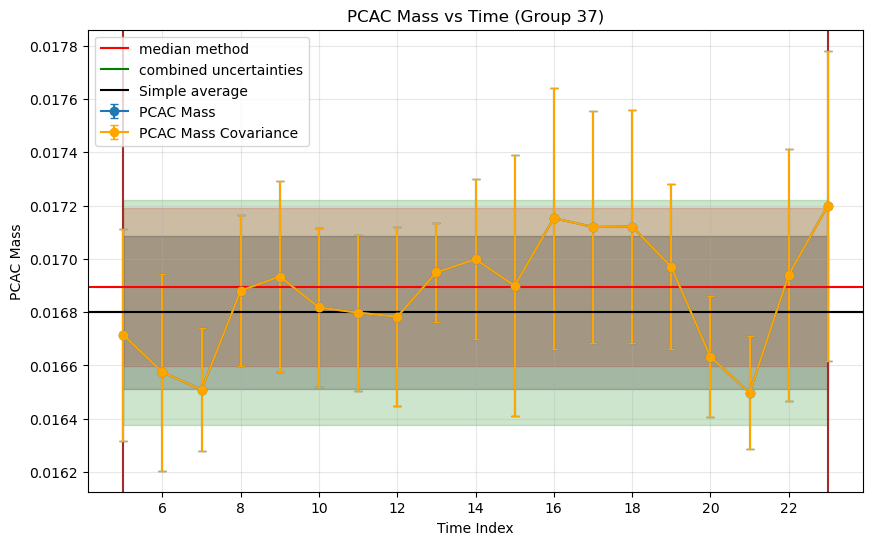

In [ ]:
from matplotlib.ticker import MaxNLocator

%matplotlib inline

if target_group:
    # Use context manager to temporarily work with just this group
    with analyzer:
        analyzer.active_groups = {target_group}

        # Load JAckknife replicas in a 2D array
        PCAC_mass_correlator_replicas = analyzer.dataset_values(
            "Jackknife_samples_of_PCAC_mass_correlator_values_2D_array"
        )[0]

        N, T = np.shape(PCAC_mass_correlator_replicas)

        # Symmetrize each replica
        PCAC_mass_correlator_replicas_symmetrized = np.array(
            [
                symmetrization(PCAC_mass_correlator_replica)
                for PCAC_mass_correlator_replica in PCAC_mass_correlator_replicas
            ]
        )

        # Calculate the weighted jackknife average
        PCAC_mass_correlator_average = jackknife_average(
            PCAC_mass_correlator_replicas_symmetrized
        )
        # PCAC_mass_correlator_average = symmetrization(PCAC_mass_correlator_average)
        PCAC_mass_correlator_average = PCAC_mass_correlator_average[: T // 2]

        PCAC_mass_correlator_average_cov = jackknife_average(
            PCAC_mass_correlator_replicas_symmetrized, use_covariance=True
        )

        # PCAC_mass_correlator_average_cov = symmetrization(
        #     PCAC_mass_correlator_average_cov
        # )
        PCAC_mass_correlator_average_cov = PCAC_mass_correlator_average_cov[: T // 2]

        plateau_start, plateau_final, _ = detect_plateau_region(
            PCAC_mass_correlator_average_cov, sigma_threshold=2
        )

        # Plot PCAC_mass_correlator
        plt.figure(figsize=(10, 6))
        plt.xlabel("Time Index")
        plt.ylabel("PCAC Mass")
        plt.title(f"PCAC Mass vs Time (Group {jackknife_analysis_number})")
        plt.grid(True, alpha=0.3)

        plt.axvline(plateau_start, color="brown")
        plt.axvline(plateau_final - 1, color="brown")

        initial_shift = 5
        y = PCAC_mass_correlator_average[initial_shift:]
        time_indices = np.arange(initial_shift, len(y) + initial_shift)
        plt.errorbar(
            time_indices,
            gv.mean(y),
            yerr=gv.sdev(y),
            fmt="o-",
            capsize=3,
            label="PCAC Mass",
        )

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        y = PCAC_mass_correlator_average_cov[initial_shift:]
        plt.errorbar(
            time_indices,
            gv.mean(y),
            yerr=gv.sdev(y),
            fmt="o-",
            capsize=3,
            color="orange",
            label="PCAC Mass Covariance",
        )

        plateau_value, _ = plateau_estimate(
            PCAC_mass_correlator_replicas_symmetrized,
            plateau_start,
            plateau_final,
            method="median",
            use_inverse_variance=True,
        )
        plt.axhline(plateau_value.mean, color="red", label="median method")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            plateau_value.mean - plateau_value.sdev,
            plateau_value.mean + plateau_value.sdev,
            color="red",
            alpha=0.2,
        )

        plateau_value, _ = plateau_estimate(
            PCAC_mass_correlator_replicas_symmetrized,
            plateau_start,
            plateau_final,
            method="covariance_quadrature",
            use_inverse_variance=True,
        )
        plt.axhline(plateau_value.mean, color="green", label="combined uncertainties")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            plateau_value.mean - plateau_value.sdev,
            plateau_value.mean + plateau_value.sdev,
            color="green",
            alpha=0.2,
        )

        plateau_value, _ = plateau_estimate(
            PCAC_mass_correlator_replicas_symmetrized,
            plateau_start,
            plateau_final,
            method="simple",
            use_inverse_variance=True,
        )
        plt.axhline(plateau_value.mean, color="black", label="Simple average")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            plateau_value.mean - plateau_value.sdev,
            plateau_value.mean + plateau_value.sdev,
            color="black",
            alpha=0.2,
        )

        plt.legend()
        plt.show()

### Pion mass

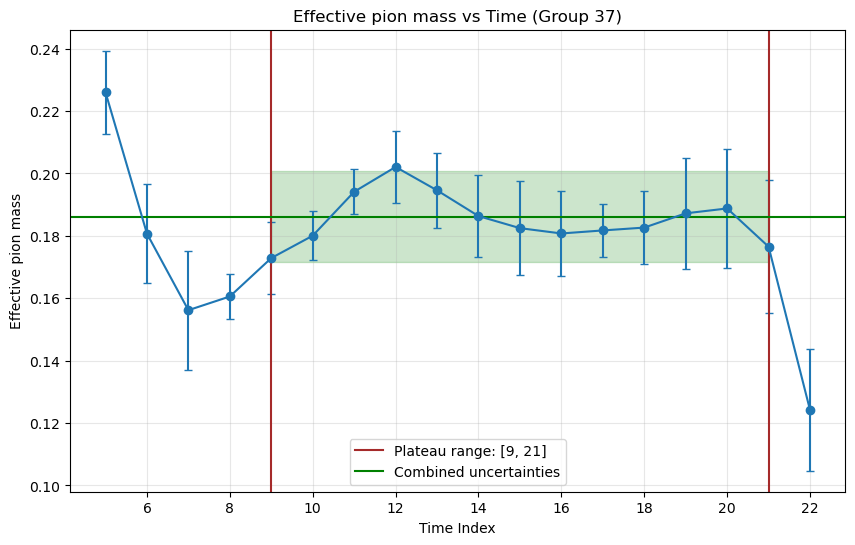

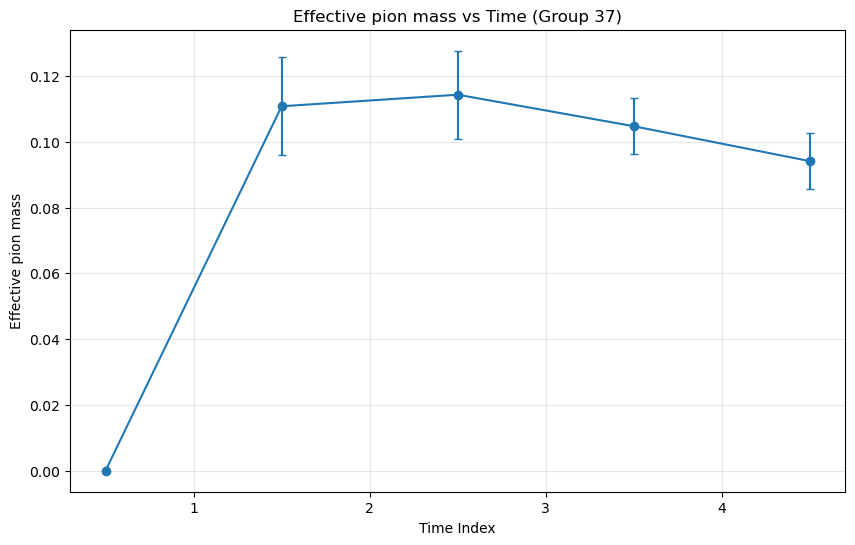

/nvme/h/cy22sg1/qpb_data_analysis/core/library/effective_mass.py:157: RuntimeWarning: invalid value encountered in log
  result = p[0] + np.log(ratio)


0.183148(13)


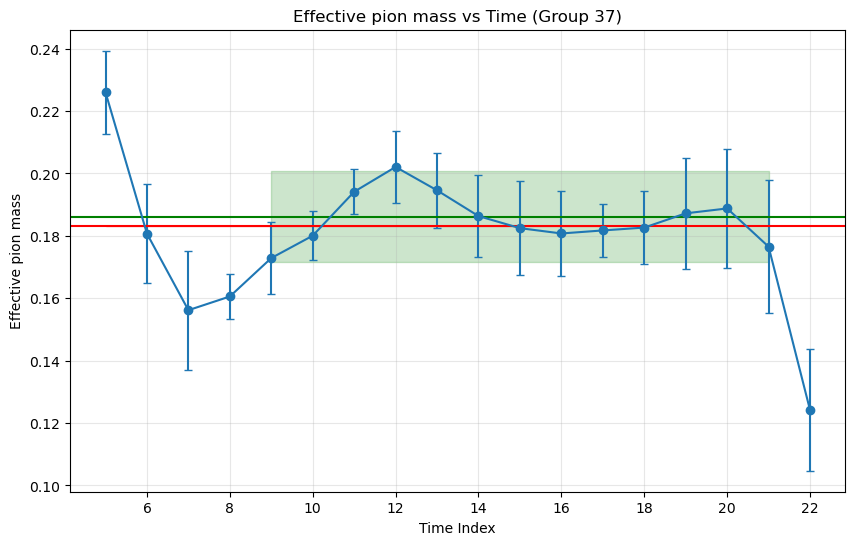

In [ ]:
%matplotlib inline

if target_group:
    # Use context manager to temporarily work with just this group
    with analyzer:
        analyzer.active_groups = {target_group}

        # Load g5g5 correlator replicas in a 2D array
        g5_g5_correlator_replicas = analyzer.dataset_values(
            "Jackknife_samples_of_g5_g5_correlator_2D_array"
        )[0]

        g5_g5_correlator_average = jackknife_average(
            g5_g5_correlator_replicas, use_covariance=True
        )

        N, T = np.shape(g5_g5_correlator_replicas)

        g5_g5_correlator_average = symmetrization(g5_g5_correlator_average)

        symmetrized_g5_g5_correlator_replicas = np.array(
            [
                symmetrization(g5_g5_correlator_replica)
                for g5_g5_correlator_replica in g5_g5_correlator_replicas
            ]
        )

        effective_mass_correlator_replicas = np.array(
            [
                effective_mass.calculate_two_state_periodic_effective_mass_correlator(
                    symmetrized_g5_g5_correlator_replica
                )
                for symmetrized_g5_g5_correlator_replica in symmetrized_g5_g5_correlator_replicas
            ]
        )

        # Effective mass in an array of T//2 size
        effective_mass_correlator_average = jackknife_average(
            effective_mass_correlator_replicas, use_covariance=True
        )

        plateau_start, plateau_final, _ = detect_plateau_region(
            effective_mass_correlator_average, sigma_threshold=1.5
        )

        # Plot effective pion mass
        plt.figure(figsize=(10, 6))
        plt.xlabel("Time Index")
        plt.ylabel("Effective pion mass")
        plt.title(f"Effective pion mass vs Time (Group {jackknife_analysis_number})")
        plt.grid(True, alpha=0.3)

        initial_shift = 5
        y = effective_mass_correlator_average[initial_shift:]
        time_indices = np.arange(initial_shift, len(y) + initial_shift)

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.errorbar(
            time_indices,
            gv.mean(y),
            yerr=gv.sdev(y),
            fmt="o-",
            capsize=3,
        )

        plt.axvline(plateau_start, color="brown")
        plt.axvline(
            plateau_final - 1,
            color="brown",
            label=f"Plateau range: [{plateau_start}, {plateau_final-1}]",
        )

        plateau_value, _ = plateau_estimate(
            effective_mass_correlator_replicas,
            plateau_start,
            plateau_final,
            method="covariance_quadrature",
            use_inverse_variance=True,
        )
        plt.axhline(plateau_value.mean, color="green", label="Combined uncertainties")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            plateau_value.mean - plateau_value.sdev,
            plateau_value.mean + plateau_value.sdev,
            color="green",
            alpha=0.2,
        )

        plt.legend()
        plt.show()

        # Plot y(t)/y(t+1)
        plt.figure(figsize=(10, 6))
        plt.xlabel("Time Index")
        plt.ylabel("Effective pion mass")
        plt.title(f"Effective pion mass vs Time (Group {jackknife_analysis_number})")
        plt.grid(True, alpha=0.3)

        initial_shift = 0
        y = (
            effective_mass_correlator_average
            / np.roll(effective_mass_correlator_average, shift=-1)
            * np.exp(-plateau_value)
        )

        y = y[1 : plateau_start - 1]
        mask = y > 1
        y = y[mask]

        # Multiply y by its next 4 forward-shifted versions
        for shift in range(1, len(y)):
            y = y * np.roll(y, shift=-shift)
        y = y[initial_shift : plateau_start - 1] - 1
        r_guess = y[0]
        time_indices = np.arange(initial_shift + 0.5, len(y) + 0.5 + initial_shift)

        y = -np.log(y / r_guess) / (time_indices)

        c_guess = np.mean(y[1:])

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.errorbar(
            time_indices,
            gv.mean(y),
            yerr=gv.sdev(y),
            fmt="o-",
            capsize=3,
        )

        plt.show()

        # Plot effective pion mass
        plt.figure(figsize=(10, 6))
        plt.xlabel("Time Index")
        plt.ylabel("Effective pion mass")
        plt.title(f"Effective pion mass vs Time (Group {jackknife_analysis_number})")
        plt.grid(True, alpha=0.3)

        initial_shift = 5
        y = effective_mass_correlator_average[initial_shift:]
        time_indices = np.arange(initial_shift, len(y) + initial_shift)

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.errorbar(
            time_indices,
            gv.mean(y),
            yerr=gv.sdev(y),
            fmt="o-",
            capsize=3,
        )

        plt.axhline(plateau_value.mean, color="green", label="Combined uncertainties")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            plateau_value.mean - plateau_value.sdev,
            plateau_value.mean + plateau_value.sdev,
            color="green",
            alpha=0.2,
        )

        time_indices = np.arange(1, T//2)
        individual_plateau_mass_list = []
        effective_mass_two_state_fit_p0 = gv.mean([plateau_value, r_guess, c_guess])
        for effective_mass_correlator_replica in effective_mass_correlator_replicas:

            y = gv.gvar(
                effective_mass_correlator_replica,
                gv.sdev(effective_mass_correlator_average)
            )
            try:
                effective_mass_two_state_fit = lsqfit.nonlinear_fit(
                    data=(time_indices[1:-1], y[1:-1]),
                    p0=effective_mass_two_state_fit_p0,
                    fcn=effective_mass.two_state_fit_function,
                    debug=True,
                )
            except:
                print("Shhiiit!!")


            individual_plateau_mass_list.append(effective_mass_two_state_fit.p[0])

        individual_plateau_mass_list = gv.mean(individual_plateau_mass_list)
        two_state_plateau_value_mean = np.mean(individual_plateau_mass_list)
        two_state_plateau_value = gv.gvar(
            two_state_plateau_value_mean,
            (N - 1) / N * np.sum((individual_plateau_mass_list - two_state_plateau_value_mean)** 2)
        )
        plt.axhline(two_state_plateau_value.mean, color="red", label="Combined uncertainties")
        plt.fill_between(
            time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
            two_state_plateau_value.mean - two_state_plateau_value.sdev,
            two_state_plateau_value.mean + two_state_plateau_value.sdev,
            color="red",
            alpha=0.2,
        )


        print(two_state_plateau_value)

        # fitted_line = effective_mass.two_state_fit_function(
        #     time_indices[plateau_start - initial_shift : plateau_final - initial_shift], effective_mass_two_state_fit.p
        # )

        # plt.plot(
        #     time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
        #     gv.mean(fitted_line),
        #     "r--",
        #     # label=label_string,
        # )

        # print(fitted_line[plateau_start - initial_shift : plateau_final - initial_shift])
        # # plt.fill_between(
        # #     time_indices[plateau_start - initial_shift : plateau_final - initial_shift],
        # #     fitted_line[plateau_start - initial_shift].mean
        # #     - fitted_line[plateau_start - initial_shift].sdev,
        # #     fitted_line[plateau_final - initial_shift].mean
        # #     + fitted_line[plateau_final - initial_shift].sdev,
        # #     color="red",
        # #     alpha=0.2,
        # # )

        # plt.legend()
        plt.show()

In [11]:
# #

# effective_mass_guess = plateau_value.mean
# single_state_non_periodic_fit_range = np.arange(plateau_start, plateau_final)

# amplitude_factor_guess = (
#     momentum_correlator.amplitude_of_single_state_non_periodic_correlator(
#         g5_g5_correlator_average,
#         effective_mass_guess,
#         initial_shift + (plateau_final - initial_shift) // 2,
#     )
# )
# amplitude_factor_guess = gv.mean(amplitude_factor_guess)

# time_indices = np.arange(len(g5_g5_correlator_average))

# g5_g5_correlator_single_state_non_periodic_fit_p0 = [
#     amplitude_factor_guess,
#     effective_mass_guess,
# ]
# g5_g5_correlator_single_state_fit = lsqfit.nonlinear_fit(
#     data=(
#         time_indices[single_state_non_periodic_fit_range],
#         g5_g5_correlator_average[single_state_non_periodic_fit_range],
#     ),
#     p0=g5_g5_correlator_single_state_non_periodic_fit_p0,
#     fcn=momentum_correlator.single_state_non_periodic_correlator,
#     debug=True,
# )

# # Plot g5g5 correlator
# plt.figure(figsize=(10, 6))
# plt.xlabel("Time Index")
# plt.ylabel("g5-g5")
# plt.title(f"g5-g5 vs Time (Group {jackknife_analysis_number})")
# plt.grid(True, alpha=0.3)

# plt.yscale("log")

# initial_shift = 10

# y = g5_g5_correlator_average[initial_shift:-initial_shift]
# time_indices = np.arange(initial_shift, len(y) + initial_shift)

# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.errorbar(
#     time_indices,
#     gv.mean(y),
#     yerr=gv.sdev(y),
#     fmt="o-",
#     capsize=3,
# )

# plt.plot(
#     time_indices,
#     momentum_correlator.single_state_periodic_correlator(
#         time_indices, gv.mean(g5_g5_correlator_single_state_fit.p)
#     ),
#     "r--",
#     label="Guess",
# )

# plt.show()

# initial_shift = 0
# y = effective_mass_correlator_average[initial_shift:]
# time_indices = np.arange(initial_shift, initial_shift + len(y))

# c_guess = np.log(
#     (y[1] - amplitude_factor_guess * np.exp(-effective_mass_guess))
#     / (y[2] - amplitude_factor_guess * np.exp(-2 * effective_mass_guess))
# )
# c_guess = gv.mean(c_guess)

# r_guess = (np.exp(np.sum(y) - len(y) * effective_mass_guess) - 1) / np.exp(
#     -c_guess
# )
# r_guess = gv.mean(r_guess)

# effective_mass_two_state_fit_p0 = [effective_mass_guess, r_guess, c_guess]

# effective_mass_two_state_fit = lsqfit.nonlinear_fit(
#     data=(time_indices, y),
#     p0=effective_mass_two_state_fit_p0,
#     fcn=effective_mass.two_state_fit_function,
#     debug=True,
# )

# # Plot effective pion mass
# plt.figure(figsize=(10, 6))
# plt.xlabel("Time Index")
# plt.ylabel("Effective pion mass")
# plt.title(f"Effective pion mass vs Time (Group {jackknife_analysis_number})")
# plt.grid(True, alpha=0.3)

# initial_shift = 5
# y = effective_mass_correlator_average[initial_shift:]
# time_indices = np.arange(initial_shift, len(y) + initial_shift)

# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.errorbar(
#     time_indices,
#     gv.mean(y),
#     yerr=gv.sdev(y),
#     fmt="o-",
#     capsize=3,
# )

# plt.plot(
#     time_indices,
#     effective_mass.two_state_fit_function(
#         time_indices, gv.mean(effective_mass_two_state_fit.p)
#     ),
#     "r--",
#     label="Guess",
# )
# pion_effective_mass_estimate = effective_mass_two_state_fit.p[0]
# plt.fill_between(
#     time_indices,
#     pion_effective_mass_estimate.mean - pion_effective_mass_estimate.sdev,
#     pion_effective_mass_estimate.mean + pion_effective_mass_estimate.sdev,
#     color="r",
#     alpha=0.2,
# )

# # effective_mass.two_state_fit_function

# plt.show()